In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import csv
import numpy as np
import urllib.request
import requests
import json

<h1>Louisville Metro Police Department Bias Study </h1>
The below section imports the LMPD stops

In [222]:
# Imports the first csv file    
df = pd.read_csv (r'stops.csv')

filename = 'stops.csv'
with open('stops.csv') as f:
    reader = csv.reader(f)
    header_row = next(reader)
#To display the headers 
print(header_row)
# print("This is the total number of rows in the file:", '\n' ,len(df))

['\ufeffTYPE_OF_STOP', 'CITATION_CONTROL_NUMBER', 'ACTIVITY_RESULTS', 'OFFICER_GENDER', 'OFFICER_RACE', 'OFFICER_AGE_RANGE', 'ACTIVITY_DATE', 'ACTIVITY_TIME', 'ACTIVITY_LOCATION', 'ACTIVITY_DIVISION', 'ACTIVITY_BEAT', 'DRIVER_GENDER', 'DRIVER_RACE', 'DRIVER_AGE_RANGE', 'NUMBER_OF_PASSENGERS', 'WAS_VEHCILE_SEARCHED', 'REASON_FOR_SEARCH', 'ObjectId']


This drops the data we dont need and renames some of the columns. 

In [223]:
# Drops the columns that arent needed
df.drop(columns=['CITATION_CONTROL_NUMBER', 'ACTIVITY_DATE', 'ACTIVITY_TIME', 'ACTIVITY_LOCATION', 'ACTIVITY_DIVISION', 'ACTIVITY_BEAT', 'NUMBER_OF_PASSENGERS', 'WAS_VEHCILE_SEARCHED', 'REASON_FOR_SEARCH', 'ObjectId'], inplace=True)
# Renames the data o_xxx is for officer data on citation stops d_xxx is for driver data
df.rename(columns={'TYPE_OF_STOP':'stop', 'ACTIVITY_RESULTS':'action', 'OFFICER_GENDER':'o_gender', 'OFFICER_RACE':"o_race", 'OFFICER_AGE_RANGE':"o_age", 'DRIVER_GENDER':'d_gender', 'DRIVER_RACE':"d_race", 'DRIVER_AGE_RANGE':"d_age"}, inplace=True)
# Displays the new dataframe 
df.head()

,stop,action,o_gender,o_race,o_age,d_gender,d_race,d_age
0,COMPLAINT/CRIMINAL VIOLATION,CITATION ISSUED,M,WHITE,21 - 30,M,BLACK,16 - 19
1,TRAFFIC VIOLATION,CITATION ISSUED,F,WHITE,21 - 30,M,WHITE,16 - 19
2,COMPLAINT/CRIMINAL VIOLATION,CITATION ISSUED,M,WHITE,21 - 30,F,BLACK,31 - 40
3,TRAFFIC VIOLATION,CITATION ISSUED,M,WHITE,31 - 40,M,HISPANIC,20 - 25
4,COMPLAINT/CRIMINAL VIOLATION,CITATION ISSUED,M,WHITE,31 - 40,M,HISPANIC,20 - 25


Removes the Unknown races of the officers on the column. 
<br>
The verifies that the Unknow is removed. 

In [224]:
df['o_race'] = df['o_race'].replace(['UNKNOWN'], ' ')
df.drop(df.loc[df['o_race']==' '].index, inplace=True)
df.sort_values(by=['o_race'], inplace=True)
# Identifies the races of the officers. 
df.o_race.unique()

array(['ASIAN', 'BLACK', 'HISPANIC', 'WHITE'], dtype=object)

This imports the LMPD employee data. 

In [225]:
# This brings in the second set of data
df3 = pd.read_csv (r'employee.csv')

filename = 'employee.csv'
with open('employee.csv') as f:
    reader = csv.reader(f)
    header_row = next(reader)
#To display the headers
# print(header_row)
# print("This is the total number of rows in the file:", '\n' ,len(df))
# df3.head()

This replaces the vales with simple unique values. Then drops columns that we dont need. 

In [226]:
# Drops the columns that are not needed 
df3.drop(columns=['AOC_CODE', 'RANK_TITLE', 'OFFICER_DIVISION', 'OFFICER_ASSIGNMENT', 'OFFICER_YEARS_SWORN', 'ObjectId'], inplace=True)
# Renames the colums to simple labels oh_xxx Officer Hired xxx 
df3.rename(columns={'OFFICER_SEX':'oh_sex', 'OFFICER_RACE':'oh_race', 'OFFICER_AGE_RANGE':'oh_age_range', 'OFFICER_AGE':"oh_age"}, inplace=True)
# df3.head()


This drops rows where the officers age isn't reported. 

In [227]:
# Drops all the rows that dont have an age for the officer
df3.drop(df3.loc[df3['oh_age']==0].index, inplace=True)
df3.sort_values(by=['oh_age'], inplace=True)
# df3.head(15)

This drops rows where the officers race isn't reported. 

In [228]:
# Replaces the U value
df3['oh_race'] = df3['oh_race'].replace(['U '], ' ')
df3.drop(df3.loc[df3['oh_race']==' '].index, inplace=True)
df3.sort_values(by=['oh_race'], inplace=True)
# df3.head(15)
# Verfies the U value replaced 
df3.oh_race.unique()

array(['A ', 'B ', 'H ', 'W '], dtype=object)

<h2> Police Age stats </h2>

In [229]:
# stats ran on officers age
print("The mean officer age is:", df3['oh_age'].mean())
print("The max officer age is:", df3['oh_age'].max())
print("The min officer age is:", df3['oh_age'].min())


The mean officer age is: 45.23181304183943
The max officer age is: 81
The min officer age is: 21


 This fills the second requirement of joining 2 data frames. 

In [230]:
# Joins the 2 csv files. 
df4 =  pd.concat([df, df3], axis = 1, join="inner")
df4.head()
# print(header_row)

,stop,action,o_gender,o_race,o_age,d_gender,d_race,d_age,oh_sex,oh_race,oh_age_range,oh_age
647,TRAFFIC VIOLATION,CITATION ISSUED,M,ASIAN,21 - 30,M,BLACK,26 - 30,M,W,50 - 59,53
466,TRAFFIC VIOLATION,CITATION ISSUED,M,ASIAN,31 - 40,M,BLACK,31 - 40,M,W,50 - 59,50
2579,TRAFFIC VIOLATION,CITATION ISSUED,M,ASIAN,31 - 40,F,HISPANIC,31 - 40,M,W,21 - 29,25
221,TRAFFIC VIOLATION,CITATION ISSUED,M,ASIAN,31 - 40,F,WHITE,20 - 25,M,W,40 - 49,46
2587,TRAFFIC VIOLATION,CITATION ISSUED,M,ASIAN,21 - 30,F,WHITE,31 - 40,M,W,21 - 29,25


Below are dictionaries of the drivers sex, then a dictionary of the officers sex. 

In [231]:
# dict of drivers 
d_gender = dict({
    'Driver Female' : sum(df4.d_gender == 'F'),
    'Driver Male' : sum(df4.d_gender == 'M')
})

# print(d_gender)

# dict of officers 
oh_sex = dict( {
    'Male Officer' : sum(df4.oh_sex == 'M'),
    'Female Offier' : sum(df4.oh_sex == 'F')
})

# print(oh_sex)


Pie plot the LMPD sex break down. 

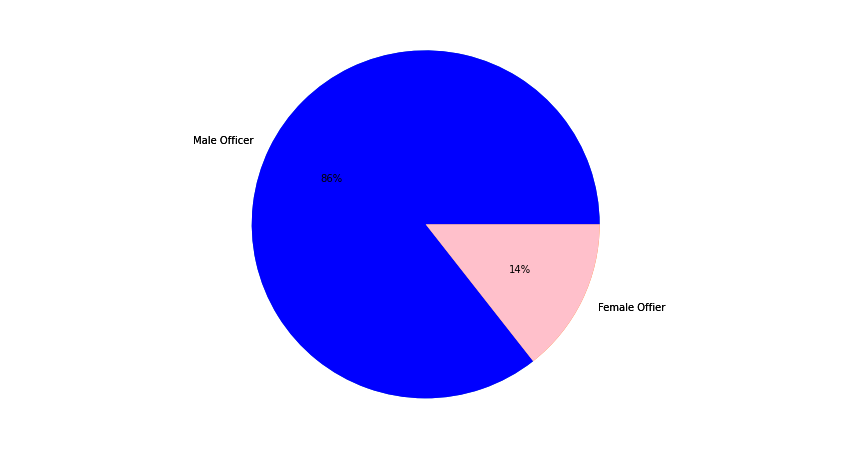

In [232]:
# officer data as pie chart 
# Data to plot
labels = []
sizes = []

for x, y in oh_sex.items():
    labels.append(x)
    sizes.append(y)

# Plot
plt.pie(sizes, labels=labels)

plt.axis('equal')
plt.pie(sizes, labels=labels, autopct='%1.0f%%', colors = ['blue', 'pink'])
plt.show()

Pie plot of the cited sex break down. 

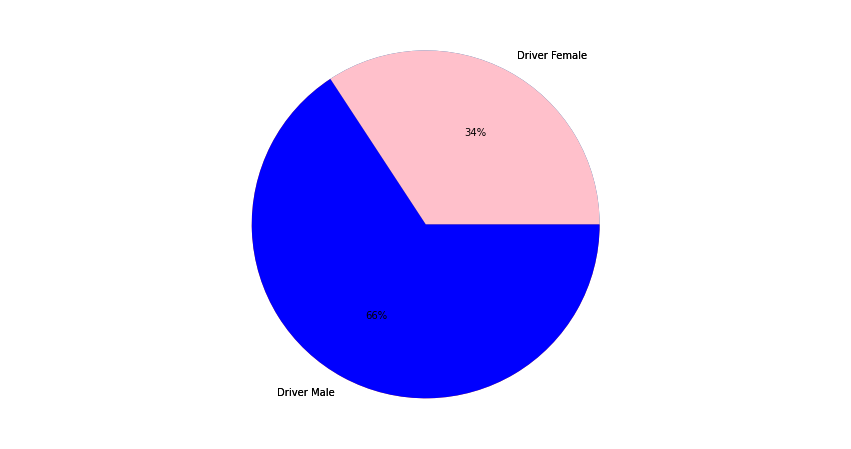

In [233]:
# driver data as pie
# Data to plot
labels = []
sizes = []

for x, y in d_gender.items():
    labels.append(x)
    sizes.append(y)

# Plot
plt.pie(sizes, labels=labels)

plt.axis('equal')
plt.pie(sizes, labels=labels, autopct='%1.0f%%', colors = ['pink', 'blue'])
plt.show()

This compares the Officers race to the race of the cited civilans. 

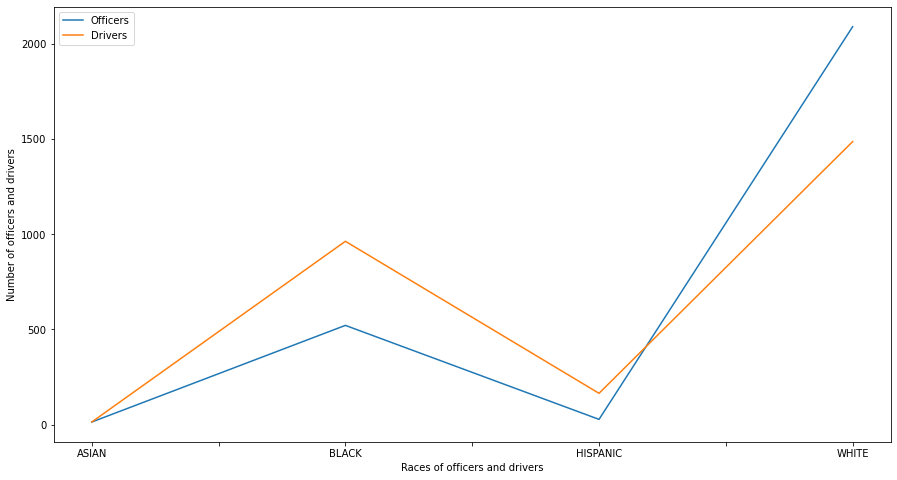

In [243]:
oraces =  df4.groupby('o_race')['o_race'].count().plot(legend=True)
draces =  df4.groupby('d_race')['d_race'].count().plot(legend=True, xlabel='Races of officers and drivers', ylabel='Number of officers and drivers'), plt.legend(['Officers', "Drivers"])
# print(oraces)
# print(draces)


This counts the oficer race compared to the drivers race. 

In [235]:
# seperates and counts citations by officer race then driver race. 
df5 = df4.groupby(["o_race"])["d_race"].value_counts()
print(df5)

o_race    d_race  
ASIAN     BLACK          6
          WHITE          6
          HISPANIC       1
BLACK     WHITE        279
          BLACK        190
          HISPANIC      34
          ASIAN          2
HISPANIC  WHITE         18
          BLACK          6
          HISPANIC       3
WHITE     WHITE       1184
          BLACK        761
          HISPANIC     126
          ASIAN         11
Name: d_race, dtype: int64


(<AxesSubplot:xlabel='Officers then drivers Race', ylabel='Number of citations'>,
 <matplotlib.legend.Legend at 0x7fa37a507d00>)

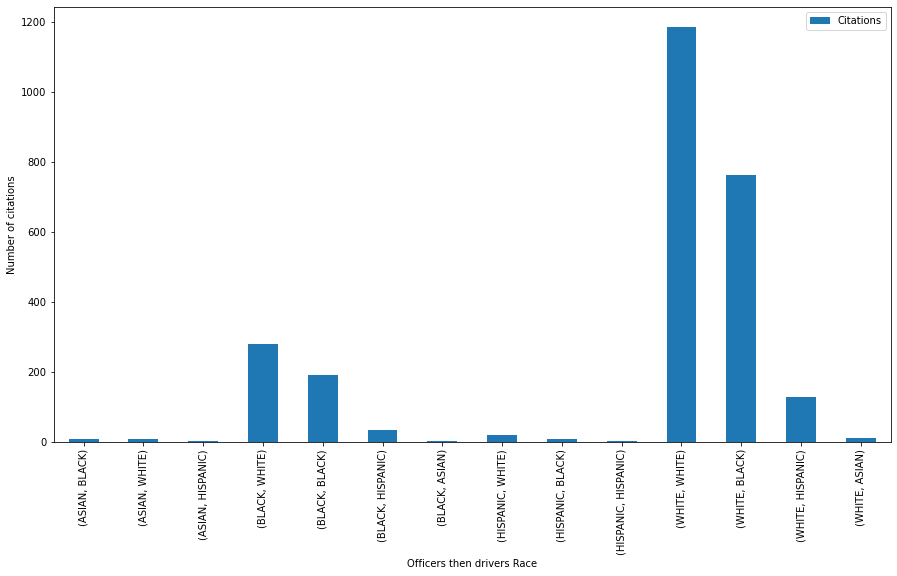

In [236]:
df4.groupby(["o_race"])["d_race"].value_counts().plot(kind='bar', legend=True, xlabel='Officers then drivers Race', ylabel='Number of citations'), plt.legend(['Citations'])
# ax.bar_label(ax.containers[0])

This is the louisville poputation male to female percent and the officer and drivers male female makeup. 

In [237]:
# gets counts gender counts by citation to determing percentages
df14 = df4.groupby(["o_gender"])["d_gender"].value_counts()

# louisville population % 
louisville_population = { 
    'fp' : [51.6],
    'mp' : [48.4],
    }

# print(df14)

# print(louisville_population)

# female officer citations 
ofc = {
    'cm' : [69/102*100],
    "cf" : [33/102*100]
}

# male officer citations 
omc = {
    'ccm' : [1682/2564*100],
    'ccf' : [882/2564*100]
}

# print(omc)
# print(ofc)

Compares male and female officer citations to the population. 

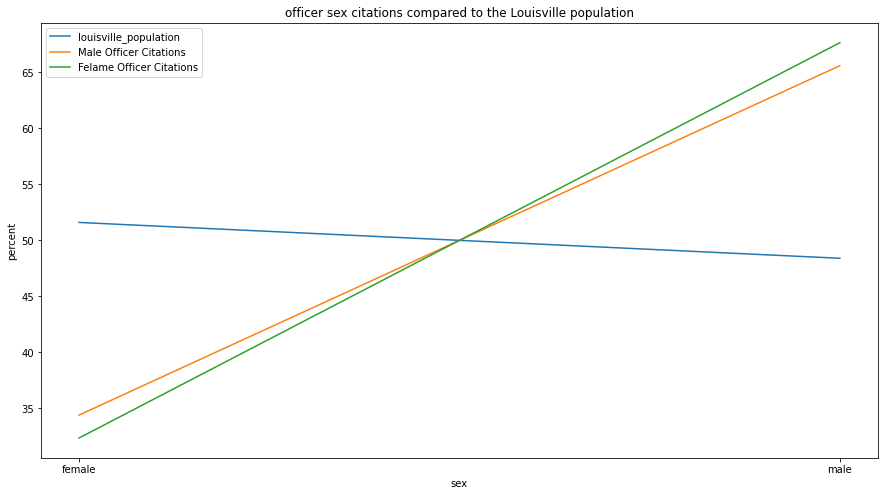

In [238]:
# graph of above data to show males have a higher citation rate while population is almost equal   
# x axis values 
x = ['female', 'male'] 

# corresponding y axis values 
ys = {
    'louisville_population' : [51.6, 48.4],
    'Male Officer Citations' : [34.40, 65.60],
    'Felame Officer Citations' : [32.35, 67.65]
} 
 

for y in ys:
  plt.plot(x, ys[y], label=y)
  # print('For Month: ', y, "   Values: ", ys[y])

plt.legend()

    
# naming the x axis 
plt.xlabel('sex')

# naming the y axis 
plt.ylabel('percent') 
   
# giving a title to my graph 
plt.title('officer sex citations compared to the Louisville population') 
    
# function to show the plot 
plt.show() 

Additional calculations to check racial profiling stops.  

In [239]:
# shows citation types and race make up of the stops 
df7 = df4.groupby(["stop"])["d_race"].value_counts()
print(df7)

stop                          d_race  
COMPLAINT/CRIMINAL VIOLATION  WHITE         46
                              BLACK         34
                              HISPANIC       6
COMPLIANCE STOP (KVE ONLY)    BLACK         10
                              WHITE          3
TRAFFIC VIOLATION             WHITE       1438
                              BLACK        919
                              HISPANIC     158
                              ASIAN         13
Name: d_race, dtype: int64


Counts the officers races

In [240]:
# Counts the officers race 
df4.groupby(["o_race"])["d_race"].agg('count')

o_race
ASIAN         13
BLACK        505
HISPANIC      27
WHITE       2082
Name: d_race, dtype: int64

(<AxesSubplot:xlabel='Officers Race', ylabel='Number of police'>,
 <matplotlib.legend.Legend at 0x7fa37ad55490>)

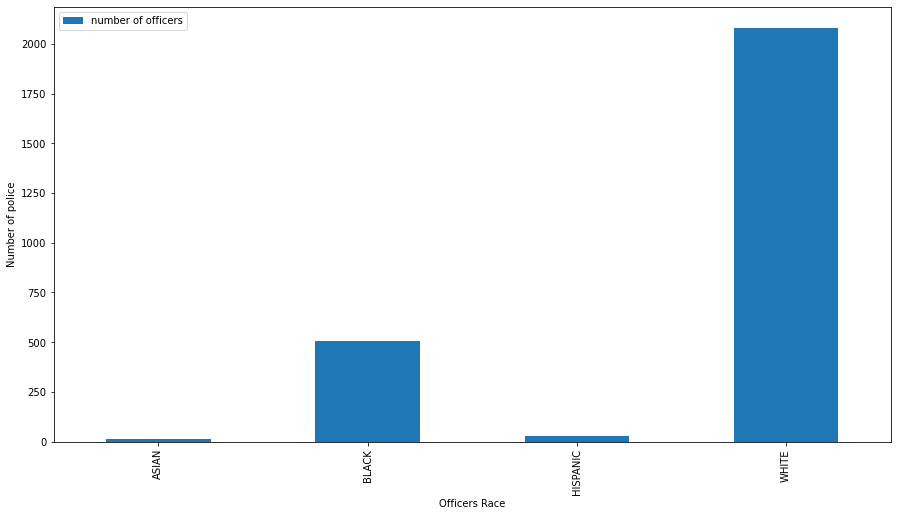

In [241]:
df4.groupby(["o_race"])["d_race"].agg('count').plot(kind='bar', legend=True, xlabel='Officers Race', ylabel='Number of police'), plt.legend(['number of officers'])
